In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm
from tvm import te

target = 'llvm'

successd...



In [2]:
def conv_gflops(oc, ic, n, k, p, s):
    on = d2ltvm.conv_out_size(n, k, p, s)
    return 2 * oc * ic * on ** 2 * k ** 2 / 1e9

def conv_timer_torch(c, n, k, ctx):
    timer = timeit.Timer(setup='import d2ltvm\n'
                        'import torch\n'
                        'c, n, k, p, s = %d, %d, %d, %d, 1\n'
                        'data, weight, bias = d2ltvm.get_conv_data_torch(c, c, n, k, p, s, ctx="%s")' % (c, n, k, (k-1) // 2, ctx),
                        stmt='out = d2ltvm.conv_torch(data, weight, bias, p, s)')
    return timer.timeit


def bench_conv_torch(sizes, ctx='cpu'):
    return [conv_gflops(c, c, n, k, (k-1) // 2, 1) / d2ltvm.bench_workload(conv_timer_torch(c, n, k, ctx)) for c, n, k in sizes]

In [3]:
channels = 2 ** np.arange(4, 9)
sizes = [(int(c), 64, 3) for c in channels]
torch_gflops = bench_conv_torch(sizes)

In [18]:
def bench_conv_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(x, k, y).mean * nrepeats
    gflops, times = [], []
    for (c, n, k) in sizes:
        args = (c, c, n, k, (k-1) // 2, 1)
        s, (X, K, Y) = func(*args)
        mod = tvm.build(s, [X, K, Y], target)
        ctx = tvm.device(target, 0)
        x, k, y = d2ltvm.get_conv_data(*args, lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
        gflops.append(conv_gflops(*args))
    return np.array(gflops) / np.array(times)

In [21]:
def default(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.conv(oc, ic, n, n, k, k, p, p, s, s)
    s = te.create_schedule(Y.op)
    
    return s, (X, K, Y)

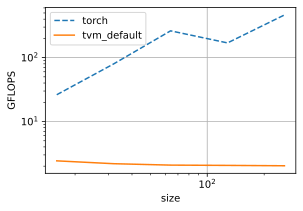

In [22]:
default_gflops = bench_conv_tvm(default, sizes, target)
d2ltvm.plot_gflops(channels, [torch_gflops, default_gflops], ['torch', 'tvm_default'])

# BlcokedConvolution

In [19]:
th, tw = 8, 8
def cached_block(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = d2ltvm.conv(oc, ic, n, n, k, k, p, p, s, s)
    s = te.create_schedule(Y.op)
    # buffer & tile
    CachedY = s.cache_write(Y, 'local')
    oc, h, w = Y.op.axis
    ho, wo, hi, wi = s[Y].tile(h, w, th, tw)
    ocxy = s[Y].fuse(oc, ho, wo)
    s[Y].parallel(ocxy)
    
    s[CachedY].compute_at(s[Y], ocxy)
    # 
    _, ch, cw = CachedY.op.axis
    ric, rkh, rkw = CachedY.op.reduce_axis
    s[CachedY].reorder(ric, rkh, rkw, ch, cw)
    s[CachedY].vectorize(cw)
    s[CachedY].unroll(ch)
    
    if PaddedX != X:
        s[PaddedX].parallel(PaddedX.op.axis[0])
    
    return s, (X, K, Y)

    
s, args = cached_block(32, 32, 64, 3, 1, 1)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(X_1: handle, K_1: handle, Y_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {X: Buffer(X_2: Pointer(float32), float32, [131072], []),
             K: Buffer(K_2: Pointer(float32), float32, [9216], []),
             Y: Buffer(Y_2: Pointer(float32), float32, [131072], [])}
  buffer_map = {X_1: X, K_1: K, Y_1: Y}
  preflattened_buffer_map = {X_1: X_3: Buffer(X_2, float32, [32, 64, 64], []), K_1: K_3: Buffer(K_2, float32, [32, 32, 3, 3], []), Y_1: Y_3: Buffer(Y_2, float32, [32, 64, 64], [])} {
  allocate(PaddedX: Pointer(global float32), float32, [139392]), storage_scope = global {
    for (i0: int32, 0, 32) "parallel" {
      for (i1: int32, 0, 66) {
        for (i2: int32, 0, 66) {
          PaddedX_1: Buffer(PaddedX, float32, [139392], [])[(((i0*4356) + (i1*66)) + i2)] = @tir.if_then_else(((((i1 < 1) || (65 <= i1)) || (i2 < 1)) || (65 <= i2)), 0f32, X[((((i0*4096) + (i1*64)) + i2) - 65)], dtype=float32)

PaddedX:
1. ric * 4356: $ric_{th}$ channel input feature \
2. floordiv(floormod(c.i.outer.fused.j.outer.fused, 64), 8) * 528: outer row number * 528(8 * 66) strides\
3. i.c * 66: inner loop row number \
4. rkh * 66: Kernel row \
(2-4 row number) \
5. floormod(c.i.outer.fused.j.outer.fused, 8) * 8: outer col number * 8 \
6. j.c: inner col number \
7. rkw: kernel col number\
(5-7 col number)

K:
1. floordiv(c.i.outer.fused.j.outer.fused, 64) * 288: $i_{th}$ outchannel * 288(32 * 9)
2. (ric * 9) + (rkh * 3): Kernel bias

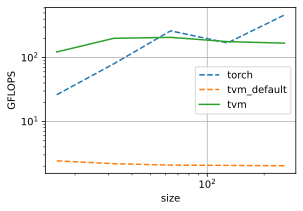

In [23]:
cached_gflops = bench_conv_tvm(cached_block, sizes, target)
d2ltvm.plot_gflops(channels, [torch_gflops, default_gflops, cached_gflops], ['torch', 'tvm_default','tvm'])

# Summary
1.We tile the input and output data of convolution as we did for matrix multiplication for better cache efficiency